In [1]:
#import main libraries (numpy for data and matplotlib for plotting)
import numpy as np 
import matplotlib.pyplot as plt
import os 

In [5]:
#User parameters
features=['A+IGBT-I', 'A+*IGBT-I', 'B+IGBT-I', 'B+*IGBT-I', 'C+IGBT-I', 'C+*IGBT-I', 'A-FLUX', 
          'B-FLUX', 'C-FLUX', 'MOD-V', 'MOD-I', 'CB-I', 'CB-V', 'DV/DT']  # waveform names to use as a header
feature_index=6  # A-flux waveform (for plotting). Use 0 for A+IGBT-I, 1 for A+*IGBT-I, and so on.
system='RFQ'     # pick a system to load and plot. Choose RFQ, DTL, CCL, or SCL

#load both waveform (X) and labels (Y) datasets for an HVCM module, e.g. RFQ, DTL, CCL, SCL
X= np.load('./hvcm/data/hvcm/%s.npy'%system)   #---> X array has shape: (pulses, times, features)
Y=np.load('./hvcm/data/hvcm/%s_labels.npy'%system, allow_pickle=True)  #---> Y array has shape: (pulses, labels) --> labels are: index, state, type
time=np.arange(X.shape[1]) * 400e-9    #create time axis based on the sampling rate 400 ns (for plotting purposes)

In [7]:
# Split X/Y arrays into fault and normal data

#obtain array indices to split normal and fault data using the second column in Y """
fault_indices, normal_indices=np.where(Y[:,1] == 'Fault')[0], np.where(Y[:,1] == 'Run')[0]

#Use the indices to assign normal data to `Xnormal` and fault data to `Xanomaly` 
Xnormal, Xanomaly = X[normal_indices,:,:], X[fault_indices,:,:]
#Use the indices to assign the labels of normal data to `Ynormal` and fault labels to `Yanomaly` 
Ynormal, Yanomaly = Y[normal_indices,:], Y[fault_indices,:]   #labels are: index, state, type

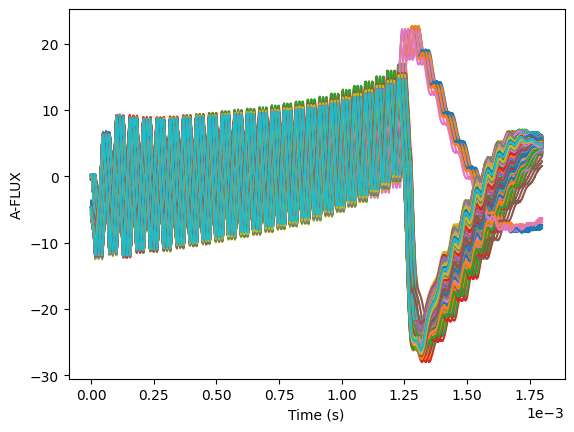

In [8]:
#plot normal pulses
#------------------------
plt.figure()
#loop over all normal pulses and plot the waveform given by feature_index
for i in range(Xnormal.shape[0]):   
    plt.plot(time, Xnormal[i,:,feature_index])   #plot A-flux normal
    # if i == 9 :
    #     break

plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index])  #add y-label
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #use sci notation
plt.show()  #show the plot

In [10]:
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [11]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [12]:


class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)

        return output, self.hidden



In [13]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [26]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        print(L)
        input_window = int(input_window)
        output_window = int(output_window)
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len


In [27]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
train = min_max_scaler.fit_transform(Xanomaly[0,:,feature_index].reshape(-1,1))
train = train.flatten()


In [38]:
iw = int((100*45)/2)
ow = int(((100*45)/2)/2)

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

4500


In [39]:
device = torch.device("cuda", index=0)
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
learning_rate=0.001
epoch = 3000
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()


In [40]:
train_dataset[0][0].shape[1]

1

In [41]:
train_dataset[0][1].shape

(1125, 1)

In [42]:
predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

In [54]:
time[:-1]

array([0.0000e+00, 4.0000e-07, 8.0000e-07, ..., 1.7984e-03, 1.7988e-03,
       1.7992e-03])

In [50]:
a[-1]

5

In [63]:
predict_time = time[-int(4500/2):]
real_time = time[-int((4500/2)/2):]

Text(0, 0.5, 'A-FLUX')

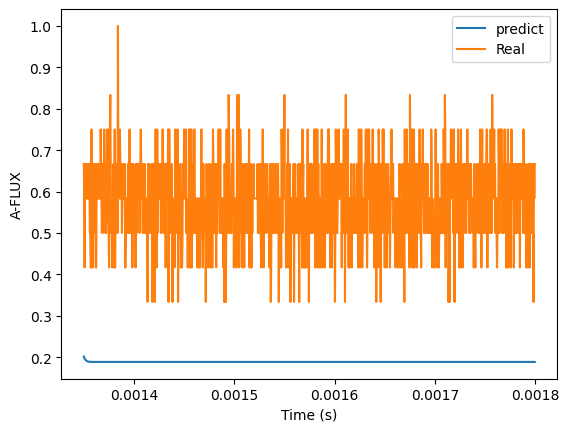

In [64]:
plt.plot(real_time, predict)
plt.plot(real_time, real)
plt.legend(["predict","Real"])
plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index]) #add y-label

In [66]:
from tqdm import tqdm
import random 

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))


 15%|█▍        | 437/3000 [3:37:38<21:16:29, 29.88s/it, loss=0.01133]


KeyboardInterrupt: 

In [ ]:
torch.save(model, '.model/lstm_scaler_3000_exp_window.h5')

In [69]:
predict = model.predict(torch.tensor(train[-int((4500/2)/2):]).reshape(-1,1).to(device).float(), target_len=ow)
real = train[-int((4500/2)/2):]

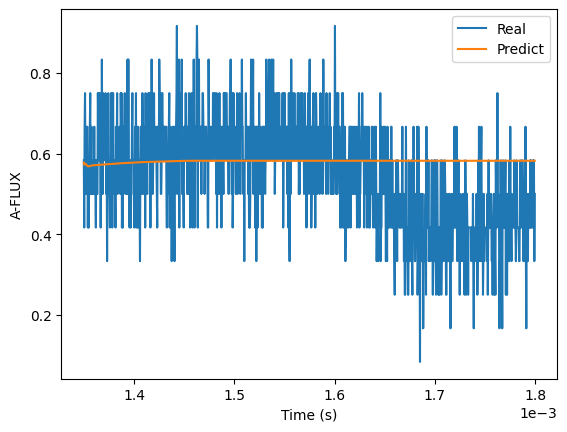

In [70]:
plt.figure()
#loop over all faulty pulses and plot the waveform given by feature_index
plt.plot(real_time, real[-int((4500/2)/2):])
plt.plot(real_time,predict)
plt.legend(["Real","Predict"])
plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index]) #add y-label
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #use sci notation
plt.show()  #show the plot